# model 4 Retrained with Loss: Mean Average Error
one-hot encoded cell_type + affinities_Transformer_CNN_BindingDB

In [1]:
import polars as pl
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# import from the auxFunctions.py file
from auxFunctions import calculate_mae_and_mrrmse, mean_rowwise_rmse_loss, custom_mean_rowwise_rmse, create_model_checkpoint, plot_training_history

## pre-process data
one-hot encode cell type
<br>map sm_name to affinities_Transformer_CNN_BindingDB.csv

In [26]:
de_train = pl.scan_parquet('./kaggledata/de_train.parquet')
de_train_df = de_train.collect().to_pandas()

# test provided by kaggle --> upload predictions to kaggle to get the score
id_map = pd.read_csv('./kaggledata/id_map.csv')

affinities = pd.read_csv('affinities_Transformer_CNN_BindingDB.csv', index_col=0)

train dataset provided by kaggle
- will be split into train/test/validation for internal testing before model is trained on the entire train and used to predict on the test in id_map

In [3]:
def extractAffinities(sm_names, affinities):
    """
    Function to extract affinities from the affinities dataframe

    Parameters:
    - sm_names: List/Array of sm_names
    - affinities: Stored affinities predicted using DeepPurpose

    Returns:
    - Affinities as a numpy array
    """
    encoded_affinities = []
    for name in sm_names:
        filtered = affinities[affinities['sm_name'] == name]
        sm_affinities = filtered.iloc[:, 2:].values[0]
        encoded_affinities.append(sm_affinities)

    np_encoded_affinities = np.array(encoded_affinities)

    return np_encoded_affinities

In [27]:
# one-hot encode cell_type
cell_type = de_train_df['cell_type'].to_numpy().reshape(-1, 1)
encoder = OneHotEncoder()
encoder.fit(cell_type)
# of type scipy.sparse._csr.csr_matrix
encoded_cell_type = encoder.transform(cell_type)

# map sm_name to affinities
sm_name = de_train_df['sm_name']

# has shape (614, 12766), of type numpy.ndarray
np_encoded_affinities = extractAffinities(sm_name, affinities)

# concatenate encoded_cell_type and np_encoded_affinities
# final shape (614, 12772)
encoded_features = np.hstack((encoded_cell_type.toarray(), np_encoded_affinities))

# wanted output
genes_lfc = de_train_df.drop(columns=['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control'])

In [28]:
# repeat for kaggle test set
kaggle_cell_type = id_map['cell_type'].to_numpy().reshape(-1, 1)
encoded_kaggle_cell_type = encoder.transform(kaggle_cell_type)

kaggle_sm_name = id_map['sm_name']
encoded_kaggle_affinities = extractAffinities(kaggle_sm_name, affinities)

# final shape (255, 12772)
encoded_kaggle_features = np.hstack((encoded_kaggle_cell_type.toarray(), encoded_kaggle_affinities))

In [29]:
# Split the data into 70% training, 15% validation, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(encoded_features, genes_lfc.values, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# used for final training before predicting on kaggle_test
full_features = encoded_features
full_labels = genes_lfc.values

## model training

In [7]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

In [15]:
tf.random.set_seed(42)

model_2 = Sequential([
    Dropout(0.2),
    Dense(6000, activation="relu"),
    Dropout(0.2),
    Dense(3000, activation="relu"),
    Dense(18211, activation="linear")
])

model_2.compile(loss=mean_rowwise_rmse_loss, 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=[custom_mean_rowwise_rmse])

history_2 = model_2.fit(X_train, y_train,
                       epochs=10,
                       validation_data=(X_val,y_val),
                       batch_size=32,
                       callbacks=[create_model_checkpoint("model_2", monitor="val_custom_mean_rowwise_rmse")])

Epoch 1/10
14/14 [==============================] - 91s 6s/step - loss: 325.7216 - custom_mean_rowwise_rmse: 311.9675 - val_loss: 0.8474 - val_custom_mean_rowwise_rmse: 0.8459
Epoch 2/10
14/14 [==============================] - 69s 4s/step - loss: 1.6685 - custom_mean_rowwise_rmse: 1.6655 - val_loss: 0.8444 - val_custom_mean_rowwise_rmse: 0.8429
Epoch 3/10
14/14 [==============================] - 64s 5s/step - loss: 1.6314 - custom_mean_rowwise_rmse: 1.5958 - val_loss: 0.8379 - val_custom_mean_rowwise_rmse: 0.8363
Epoch 4/10
14/14 [==============================] - 55s 4s/step - loss: 1.3665 - custom_mean_rowwise_rmse: 1.3800 - val_loss: 0.8328 - val_custom_mean_rowwise_rmse: 0.8311
Epoch 5/10
14/14 [==============================] - 40s 3s/step - loss: 1.3658 - custom_mean_rowwise_rmse: 1.4016 - val_loss: 0.8297 - val_custom_mean_rowwise_rmse: 0.8279
Epoch 6/10
14/14 [==============================] - 45s 3s/step - loss: 1.3671 - custom_mean_rowwise_rmse: 1.3432 - val_loss: 0.8283 - v

In [16]:
# model 3
tf.random.set_seed(42)

model_2 = Sequential([
    Dropout(0.2),
    Dense(6000, activation="relu"),
    Dropout(0.2),
    Dense(3000, activation="relu"),
    Dense(18211, activation="linear")
])

model_2.compile(loss="mae", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=[custom_mean_rowwise_rmse])

history_2 = model_2.fit(X_train, y_train,
                       epochs=10,
                       validation_data=(X_val,y_val),
                       batch_size=32,
                       callbacks=[create_model_checkpoint("model_2", monitor="val_custom_mean_rowwise_rmse")])

Epoch 1/10
14/14 [==============================] - 40s 3s/step - loss: 280.2878 - custom_mean_rowwise_rmse: 288.7963 - val_loss: 0.5612 - val_custom_mean_rowwise_rmse: 0.8451
Epoch 2/10
14/14 [==============================] - 37s 3s/step - loss: 0.9332 - custom_mean_rowwise_rmse: 1.4086 - val_loss: 0.5572 - val_custom_mean_rowwise_rmse: 0.8409
Epoch 3/10
14/14 [==============================] - 37s 3s/step - loss: 0.9372 - custom_mean_rowwise_rmse: 1.3757 - val_loss: 0.5523 - val_custom_mean_rowwise_rmse: 0.8352
Epoch 4/10
14/14 [==============================] - 38s 3s/step - loss: 0.8950 - custom_mean_rowwise_rmse: 1.3728 - val_loss: 0.5501 - val_custom_mean_rowwise_rmse: 0.8317
Epoch 5/10
14/14 [==============================] - 36s 3s/step - loss: 0.8993 - custom_mean_rowwise_rmse: 1.3980 - val_loss: 0.5493 - val_custom_mean_rowwise_rmse: 0.8300
Epoch 6/10
14/14 [==============================] - 39s 3s/step - loss: 0.8933 - custom_mean_rowwise_rmse: 1.3317 - val_loss: 0.5492 - v

### evaluate model

In [17]:
calculate_mae_and_mrrmse(model=model_2, data=X_test, y_true=y_test)

93/93 [==============================] - 6s 64ms/step
Mean Absolute Error (MAE): 0.8157590704500961
Mean Rowwise Root Mean Squared Error (MRRMSE): 1.289384422619531


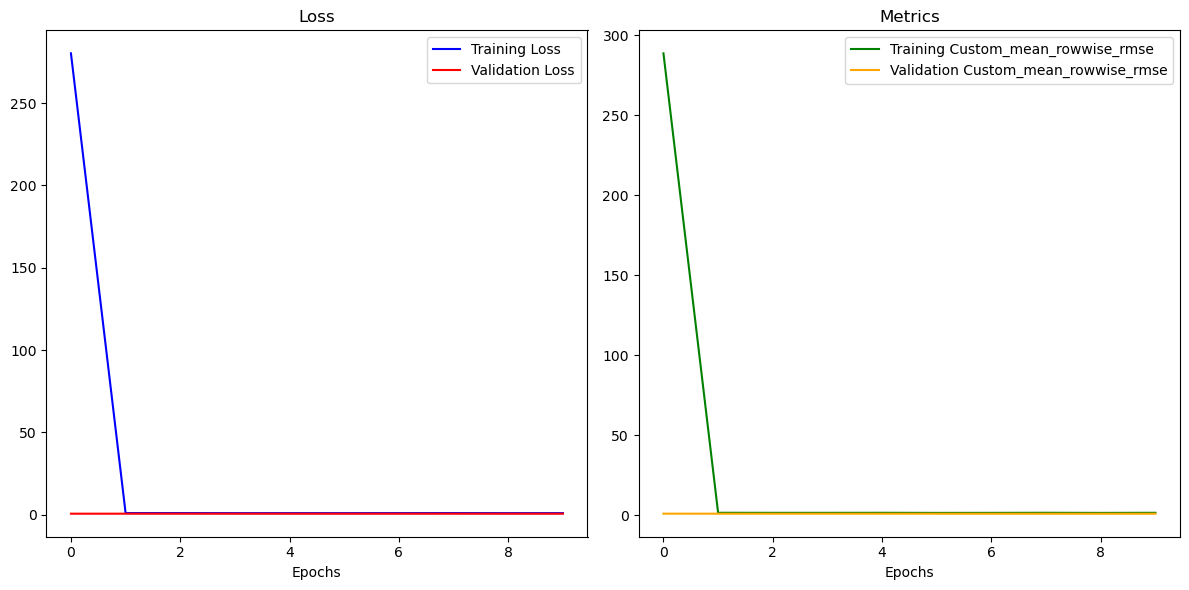

In [21]:
plot_training_history(history_2, metrics=["custom_mean_rowwise_rmse"])

In [23]:
tf.random.set_seed(42)

model_3_full = Sequential([
    Dropout(0.2),
    Dense(6000, activation="relu"),
    Dropout(0.2),
    Dense(3000, activation="relu"),
    Dense(18211, activation="linear")
])

model_3_full.compile(loss="mae", 
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=[custom_mean_rowwise_rmse])

history_3_full = model_3_full.fit(full_features, full_labels,
                       epochs=10,
                       batch_size=32)

Epoch 1/10
20/20 [==============================] - 56s 3s/step - loss: 171.4532 - custom_mean_rowwise_rmse: 176.3372
Epoch 2/10
20/20 [==============================] - 46s 2s/step - loss: 0.8895 - custom_mean_rowwise_rmse: 1.3128
Epoch 3/10
20/20 [==============================] - 47s 2s/step - loss: 0.8628 - custom_mean_rowwise_rmse: 1.2765
Epoch 4/10
20/20 [==============================] - 49s 2s/step - loss: 0.8704 - custom_mean_rowwise_rmse: 1.2840
Epoch 5/10
20/20 [==============================] - 47s 2s/step - loss: 0.8599 - custom_mean_rowwise_rmse: 1.3115
Epoch 6/10
20/20 [==============================] - 42s 2s/step - loss: 0.8505 - custom_mean_rowwise_rmse: 1.2920
Epoch 7/10
20/20 [==============================] - 47s 2s/step - loss: 0.8384 - custom_mean_rowwise_rmse: 1.2471
Epoch 8/10
20/20 [==============================] - 40s 2s/step - loss: 1.4436 - custom_mean_rowwise_rmse: 1.9083
Epoch 9/10
20/20 [==============================] - 41s 2s/step - loss: 0.8449 - cus

In [24]:
kaggle_predictions = model_3_full.predict(encoded_kaggle_features, batch_size=1)

255/255 [==============================] - 19s 74ms/step


In [25]:
sample_submission = pd.read_csv('./kaggledata/sample_submission.csv')
sample_submission.iloc[:,1:] = kaggle_predictions

sample_submission.to_csv('submission_model_3.csv', index=False)

## model elite

In [31]:
tf.random.set_seed(42)

model_elite_full = Sequential([
    Dense(6000, activation="relu"),
    Dense(12000, activation="relu"),
    Dense(10000, activation="relu"),
    Dense(18211, activation="linear")
])

model_elite_full.compile(loss="mae", 
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=[custom_mean_rowwise_rmse])

history_elite_full = model_elite_full.fit(full_features, full_labels,
                       epochs=3,
                       batch_size=32)

Epoch 1/3
20/20 [==============================] - 144s 6s/step - loss: 34283.1289 - custom_mean_rowwise_rmse: 33132.8672
Epoch 2/3
20/20 [==============================] - 110s 6s/step - loss: 0.8345 - custom_mean_rowwise_rmse: 1.2539
Epoch 3/3
20/20 [==============================] - 106s 5s/step - loss: 0.8315 - custom_mean_rowwise_rmse: 1.2438


In [32]:
kaggle_predictions = model_elite_full.predict(encoded_kaggle_features, batch_size=1)
sample_submission = pd.read_csv('./kaggledata/sample_submission.csv')
sample_submission.iloc[:,1:] = kaggle_predictions

sample_submission.to_csv('submission_model_elite.csv', index=False)

255/255 [==============================] - 56s 218ms/step
